<a href="https://colab.research.google.com/github/ViralTexts/viral-texts-classification/blob/workshop/RecipeClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Genre Classification

Last week we worked in Python, today we will work in R. This isn't for any deep, philosophical reasons. Instead, I learned to do this work in R and it's where I still feel most comfortable coding. Like last week, you don't have to know how to write any of this code to work through the lab, but there are places where you can adjust and adapt if you are comfortable doing so. Following [our reading from Ben Schmidt](https://dhdebates.gc.cuny.edu/read/untitled/section/557c453b-4abb-48ce-8c38-a77e24d3f0bd#ch48) today, we will focus on understanding the _transformations_ of our data at each stage of this process rather than trying to understand the nitty-gritty of each algorithm in use.

This workflow in this notebook is adapted from Julia Silge's [tutorial on authorship classification](https://www.r-bloggers.com/2018/12/text-classification-with-tidy-data-principles/).



In [ ]:
install.packages("tidytext")

library(tidyverse)
library(tidytext)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
clusterURL <- "https://github.com/ViralTexts/viral-texts-classification/blob/workshop/data/part-00000-b4557c14-339a-4d3b-8422-05d1babf9abc-c000.csv?raw=true"
# "https://github.com/ViralTexts/viral-texts-classification/blob/workshop/data/part-00000-a04f0e99-494e-4e07-a2a2-5570e36fe7b5-c000.csv?raw=true"
# "https://github.com/ViralTexts/viral-texts-classification/blob/workshop/data/part-00000-e3b166a2-d0ba-4fd7-b0cb-999e4d4799ca-c000.csv?raw=true"
# "https://github.com/ViralTexts/viral-texts-classification/blob/workshop/data/part-00000-e9a62088-0439-47d6-af79-3f482c36e0f7-c000.csv?raw=true"

unclassified <- read_csv(clusterURL) %>%
  select(cluster, text) %>%
  mutate(cluster = as.character(cluster)) %>%
  rename(doc_id = cluster) %>%
  distinct(doc_id, .keep_all = TRUE) %>%
  mutate(genre = "unknown")

In [ ]:
head(unclassified)

## Why Classify Genres?

_Viral Texts_ RA Avery Blankenship wrote more about why she assembled this corpus of nineteenth-century receipes in this blog post, which also links to the text files if you want to read some of them: <https://viraltexts.org/2021/02/24/c19-recipes/>. What this post helps us understand is one use case for genre classification, which is when you have an enormous dataset and want to find one specific kind of material within it. Avery want to write about how culinary texts circulated in historical newspapers, but our data comprises millions of individual reprints. In order to find those she's interested in, we need a way to identify those reprints that are likely to be about culinary topics from the larger mass of texts. We could use keyword search to do that, but classification allows to cast a wider, exploratory net. As Avery shows, classification also enables her to find texts that are structured like recipes but aren't really about food, which gives insight into the broader uses to which the recipe genre was put during the period.

In [ ]:
classified <- read_csv("https://github.com/ViralTexts/viral-texts-classification/raw/workshop/hand-tagged/recipes.csv?raw=true")

head(classified)

Rows: 1034 Columns: 3
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): doc_id, text, genre

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


doc_id,text,genre
<chr>,<chr>,<chr>
29982_anewmayonnaise.txt,"A NEW MAYONNAISE (Soyer's).--Put a quarter of a pint of stiff veal jelly (that has been nicely flavored with vegetables) on ice in a bowl, whisking it till it is a white froth; then add half a pint of salad oil and six spoonfuls of tarragon vinegar, _by degrees_, first oil, then vinegar, continually whisking till it forms a white, smooth, sauce-like cream; season with half a teaspoonful of salt, a quarter ditto of white pepper, and a very little sugar, whisk it a little more and it is ready. It should be dressed pyramidically over the article it is served with. The advantage of this sauce is that (although more delicate than any other) you may dress it to any height you like, and it will remain so any length of time; if the temperature is cool, it will remain hours without appearing greasy or melting. It is absolutely necessary, however, that it should be prepared on ice.",recipe
29982_anicelittlebreakfastdish.txt,"A NICE LITTLE BREAKFAST DISH IS made thus: Cut two long slices of cold meat and three of bread, buttered thickly, about the same shape and size; season the meat with pepper, salt, and a little finely chopped parsley; or, if it is veal, a little chopped ham; then lay one slice of bread between two of meat, and have the other two slices outside; fasten together with short wooden skewers. If you have a quick oven, put it in; and take care to baste with butter thoroughly, that the bread may be all over crisp and brown. If you can't depend on your oven, fry it in very hot fat as you would crullers; garnish with sprigs of parsley, and serve very hot.",recipe
29982_anothervealandhampie.txt,"ANOTHER VEAL AND HAM PIE, more usual, and probably the ""weal and hammer"" that ""mellered the organ"" of Silas Wegg, was manufactured by Mrs. Boffin from this recipe; it is as follows: Take the thick part of breast of veal, removing all the bones, which put on for gravy, stewing them long and slowly; put a layer of veal, pepper and salt, then a thin sprinkling of ham; if boiled, cut in slices; if raw, cut a slice in dice, which scald before using, then more veal and again ham. If force-meat balls are liked, make some force-meat as for Windsor pie, using if you prefer it chopped hard-boiled eggs in place of chopped meat, and binding into a paste with a raw egg; then make into balls, which drop into the crevices of the pie; boil two or three eggs quite hard, cut each in four and lay them round the sides and over the top, pour in about a gill of gravy, and cover the same as the Windsor pie. In either of these pies the force-meat may be left out, a sweetbread cut up, or mushrooms put in. A chicken pie to eat cold is very fine made in this way.",recipe
29982_baba.txt,"BABA.--One pound of flour; take one quarter of it, and make a sponge with half an ounce of compressed yeast and a little warm water, set it to rise, make a hole in the rest of the flour, add to it ten ounces of butter, three eggs, and a dessert-spoonful of sugar, a little salt, unless your butter salts it enough, which is generally the case. Beat all together well, then add five more eggs, one at a time, that is to say, add one egg and beat well, then another and beat again, and so on until the five are used. When the paste leaves the bowl it is beaten enough, but not before; then add the sponge to it, and a large half ounce of citron chopped, the same of currants, and an ounce and a half of sultana raisins, seedless. Let it rise to twice its size, then bake it in an oven of dark yellow paper heat; the small round babas are an innovation of the pastry-cook to enable him to sell them uncut. But the baba proper should be baked in a large, deep, upright tin, such as a large charlotte russe mold, when they keep for several days fresh, and if they get stale, make delicious fritters, soaked in sherry and dipped in frying batter. In some cases, however, it may be preferred to make them as usually seen at French pastry cook

In [ ]:
texts <- rbind(classified, unclassified)

Now we will `tokenize` the texts, which means we will break the paragraphs and sentences into smaller units—in this case individual words. This will allow us to analyze what words appear more often in recipes vs. unclassified texts, and (eventually) to predict whether any of our unclassified newspaper texts are likely to be recipes, or recipe-adjacent.

In [ ]:
tidy_texts <- texts %>%
  unnest_tokens(word, text) %>%
  group_by(word) %>%
  filter(n() > 10) %>%
  ungroup()

head(tidy_texts)

doc_id,genre,word
<chr>,<chr>,<chr>
29982_anewmayonnaise.txt,recipe,a
29982_anewmayonnaise.txt,recipe,new
29982_anewmayonnaise.txt,recipe,put
29982_anewmayonnaise.txt,recipe,a
29982_anewmayonnaise.txt,recipe,quarter
29982_anewmayonnaise.txt,recipe,of


Before we start building our model, we can simply count the words in our corpus and see which words appear most often in our recipes vs. in our unclassified texts.

In [ ]:
stopwords <- scan("https://github.com/ViralTexts/viral-texts-classification/raw/workshop/data/stopwords.txt?raw=true", what="", sep="\n") %>%
    as_tibble() %>%
    rename(word = 1)

head(stopwords)

word
<chr>
a
a's
able
about
above
according


Joining, by = "word"
Selecting by n


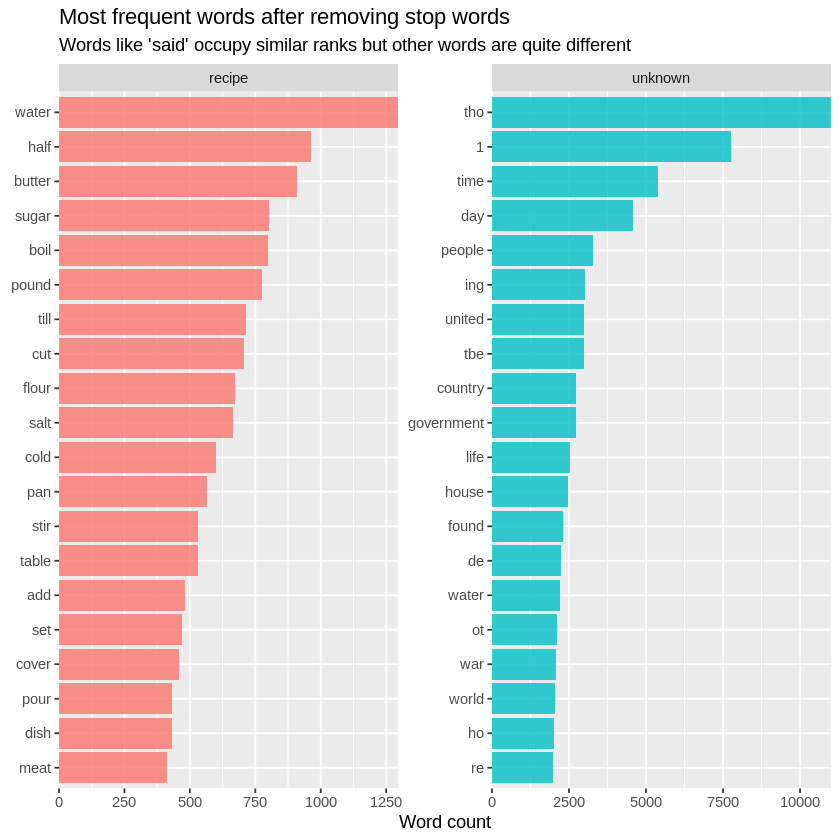

In [ ]:
tidy_texts %>%
  count(genre, word, sort = TRUE) %>%
  anti_join(stopwords) %>%
  group_by(genre) %>%
  top_n(20) %>%
  ungroup() %>%
  ggplot(aes(reorder_within(word, n, genre), n,
             fill = genre
  )) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  scale_x_reordered() +
  coord_flip() +
  facet_wrap(~genre, scales = "free") +
  scale_y_continuous(expand = c(0, 0)) +
  labs(
    x = NULL, y = "Word count",
    title = "Most frequent words after removing stop words",
    subtitle = "Words like 'said' occupy similar ranks but other words are quite different"
  )

Now we need to create a smaller dataset using a subset of our recipes. This will be called our "test data," and once we train our classifier we will use this data to verify that it is reliable. If we have trained a reliable classifier, we would expect it to identify texts we know are recipes as recipes. If it doesn't, then we would know we have more work to do.

In [ ]:
test_data <- sample_n(texts %>%
                        filter(genre == "recipe"), 
                      100, replace = FALSE) %>%
  mutate(genre = "unknown")
train_data <- anti_join(texts, test_data, by="doc_id") %>%
  mutate(genre = "recipe")

In [ ]:
# head(test_data)
# head(train_data)

This next step might seem somewhat obscure, but we can unpack it. Essentially, we are going to convert our `dataframe` of word counts into a `matrix`, which is another way to represent the data. In our matrix, each row is a document from our corpus, and each column is an individual word. The values are numeric and reflect the number of times each word appears in each document.

In [ ]:
sparse_words <- tidy_texts %>%
  count(doc_id, word) %>%
  inner_join(train_data) %>%
  cast_sparse(doc_id, word, n)


Joining, by = "doc_id"


In [ ]:
colnames(sparse_words[,10:29])
sparse_words[1:20, 10:29]

[1] "and"      "apt"      "are"      "aro"      "articles" "as"      
 [7] "asks"     "at"       "be"       "been"     "before"   "begin"   
[13] "bill"     "birthday" "bo"       "boast"    "boiled"   "boots"   
[19] "boston"   "boy"

   [[ suppressing 20 column names ‘and’, ‘apt’, ‘are’ ... ]]



20 x 20 sparse Matrix of class "dgCMatrix"
                                                 
1000442  4 1 1 1 1 3 1  3 5 1 1 1 1 1 2 1 1 1 1 1
1000626  4 . 2 . . 1 .  1 . . . . . . . . . . . .
1000735 33 . . . . 7 .  2 2 2 1 . . . . . . . . .
1000936 11 . . . . 3 .  1 1 1 1 . . . . . . . . .
1003317  3 . . . . . .  2 . 1 . . . . . . . . . .
1003330 13 . 4 . . 1 .  4 1 . . . . . 1 . . . . .
1003960 17 . . . . 1 .  2 5 1 . . . . . . . . . 2
1005163 38 . 7 . . 4 . 10 7 2 1 . 1 . . . . 1 . .
1005372  3 . . . . . .  . . . . . . . 1 . . . . .
1006314  . . . . . . .  . . . . . . . . . . . . .
100899   7 . 1 . . . .  . 2 3 . . . . . . . . . .
1009523  1 . . . . . .  1 . 1 1 . . . . . . . . .
1009531 12 . . . . . .  4 1 3 . . . . . . . . . .
1009737 12 . 3 . . 1 .  3 2 2 . . . . . . . 1 . .
1009779  8 . 1 . . 2 .  1 3 . 2 . . . . . . . . .
101052   1 . . . . . .  . . . . . . . . . . . . .
1011460  5 . 1 . . . .  . . . . . . . . . . . . .
1011644  7 . 1 . . . .  . 3 . . . . . . . . . . .
1012681

In [ ]:
texts_joined <- rbind(test_data, train_data)
dim(texts_joined)

[1] 1034    3

In [ ]:
word_rownames <- rownames(sparse_words)
texts_joined <- tibble(doc_id = word_rownames) %>%
  left_join(texts %>%
              select(doc_id, genre))

Joining, by = "doc_id"


In [ ]:
install.packages("glmnet")
install.packages("doMC")
install.packages("broom")
library(glmnet)
library(doMC)
library(broom)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’, ‘RcppEigen’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-3

Loading required package: foreach


Attaching package: ‘foreach’


The following objects are masked from ‘package:purrr’:

    accumulate, when


Loading required package: iterators

Loading required package: parallel



In [ ]:
registerDoMC(cores = 8)
is_recipe <- texts_joined$genre == "recipe"
model <-  cv.glmnet(sparse_words, is_recipe,
                   family = "binomial",
                   parallel = TRUE, keep = TRUE)

In [ ]:
coefs <- model$glmnet.fit %>%
  tidy() %>%
  filter(lambda == model$lambda.1se)

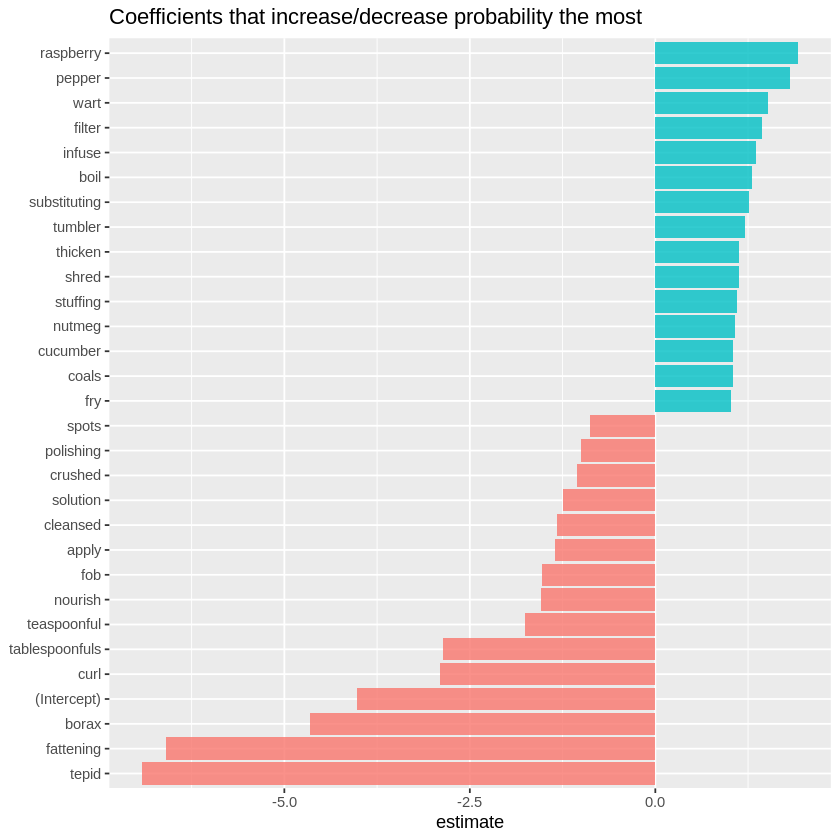

In [ ]:
coefs %>%
  group_by(estimate > 0) %>%
  top_n(15, abs(estimate)) %>%
  ungroup() %>%
  ggplot(aes(fct_reorder(term, estimate), estimate, fill = estimate > 0)) +
  geom_col(alpha = 0.8, show.legend = FALSE) +
  coord_flip() +
  labs(
    x = NULL,
    title = "Coefficients that increase/decrease probability the most"
  )

In [ ]:
coefs %>%
  arrange(desc(estimate)) %>%
  View()

term,step,estimate,lambda,dev.ratio
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
raspberry,90,1.9239403,0.002283552,0.9081861
pepper,90,1.8193004,0.002283552,0.9081861
wart,90,1.5127124,0.002283552,0.9081861
filter,90,1.4433408,0.002283552,0.9081861
infuse,90,1.3617734,0.002283552,0.9081861
boil,90,1.2989367,0.002283552,0.9081861
substituting,90,1.2677351,0.002283552,0.9081861
tumbler,90,1.2117402,0.002283552,0.9081861
thicken,90,1.1336770,0.002283552,0.9081861


In [ ]:
intercept <- coefs %>%
  filter(term == "(Intercept)") %>%
  pull(estimate)

Now we will make use of that test data we set aside above. We will merge the values for each word in our model with the words in our test data texts, and then use those values to assess the probability that our test data texts are recipes (as we know they are). You will see that even though the model identifies _most_ of our test data as recipes, it does assign a lower probability to some of them. What might that tell us about how the model understands "recipeness?"

In [ ]:
test_eval <- tidy_texts %>%
  inner_join(test_data, by="doc_id") %>%
  inner_join(coefs, by = c("word" = "term")) %>%
  group_by(doc_id) %>%
  summarize(score = sum(estimate)) %>%
  mutate(probability = plogis(intercept + score)) %>%
  left_join(texts %>%
              select(doc_id, text))

test_eval %>%
  arrange(desc(probability)) %>%
  # head(10) %>%
  # tail(10) %>%
  View()

Finally, we can use our model to predict which texts in our unclassified data are most likely to be recipes. Note that this kind of classifier doesn't make a binary (i.e. yes/no) decision about whether a text belongs to the model category. Instead, it assigns a probability that it does, based on the choices we made constructing the training set and the model. If you rerun the code above, even starting with the exact same corpus of recipes, you will see slightly different results because the step that separates the training data from the testing data is randomized, meaning precisely which texts the model trains on will be different each time the code is run. Since we know that all the hand-tagged recipes _are_ recipes, we would not expect to see radically different probabilities, but they will vary because the exact words in the training set will shift from run to run, at least in the way I've set up this code.

In [ ]:
classifications <- tidy_texts %>%
  inner_join(unclassified, by="doc_id") %>%
  inner_join(coefs, by = c("word" = "term")) %>%
  group_by(doc_id) %>%
  summarize(score = sum(estimate)) %>%
  mutate(probability = plogis(intercept + score)) %>%
  left_join(unclassified %>%
              select(doc_id, text))

Joining, by = "doc_id"


In [ ]:
classifications %>%
  arrange(desc(probability)) %>%
  head(10) %>%
  View()

doc_id      score    probability
1  60130566990 4.362730 0.5841716  
2  17181549660 4.157761 0.5336871  
3  68721237019 3.985233 0.4906074  
4  1058702     3.981925 0.4897806  
5  8592622794  3.681870 0.4155815  
6  34361081637 3.673841 0.4136330  
7  680433      3.436440 0.3574686  
8  8592127666  3.402806 0.3497810  
9  8592057054  3.362204 0.3406038  
10 2733600     3.299006 0.3265562  
   text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                

In this example of genre classification, we trained one genre—recipes—and then compared our unknown texts to that model to see how likely they were to be recipes. Because classification models like these return a probability, however, there is no reason you cannot compare the same texts to multiple genre models. One text may seem 75% likely to be a recipe, but also 60% likely to be news. [This notebook uses topics as features for classification](https://colab.research.google.com/drive/19FriuULPYgJDtZRS42o4meMbYnZ0ezYX?usp=sharing) and builds models of six different genres—advertisements, news, fiction, information, poetry, and recipes. It then assigns a probability for each genre to each unknown text, so that a single text might have some probability of belonging to multiple genres. While this might seem confusing, I actually find this aspect of classification reassuringly contextual and defensible from a humanistic perspective. We know that genres bleed into one another, and that the lines between them are rarely as bright and fixed as a catalog or index might imply. Allowing researchers to navigate multiple possibilities, at varying degrees of certainty, supports the inductive research methods preferred by humanities scholars through a computational model. 